# Import analysis packages

In [80]:
# Import relevant data analysis and visualisation packages.
from cmdstanpy import CmdStanModel, write_stan_json
import numpy as np
import os
import pandas as pd
from patsy import dmatrix
import arviz as az
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

# Measurement error models

The notebook here describes a measurement error model under the Bayesian framework. As measurement error models go it is and advanced example, however the example here is taken from a journal article by Matzke et al. (2017), whom demonstrated this particular model using the JAGS and BUGS probabilitic programming languages. Here a Stan version of that model is presented. This implementation demonstrates many of the standard advancments of hamiltonian monte carlo algorithms and Stan probablistic programming language like LKJ priors, cholesky decomposition and non-centering to improve sampling effiecency McElreath (2020).

The problem of measurement error generally in psycholgical sciences (all fields really Saccenti et al. 2020) is a result of the imperfect measurement tools. Of particular concern to Matzke et al. is the issue that measurement error can result in underestimation of correlation coefficients. Many non-Bayesian methods for correction of measurement error and their deletirious effects exist Behetsa et al. (2009). However, these methods do not carry forward uncertainty in their estimation, in the way Bayesian hierachial methods do with their shrinkage properties (Behetsa et al.).

The example below is based on estimation of the true correlation between participants specific estimated parameter from a cognitve model. The details of that model are superflious here. What matters here is that we want to estimate the correlation between these parameter values whilst accounting for measurment error of this correlation within the model.

# Steps of Bayesian data analysis

<font size = "3"> The analysis framework followed here is that presented by Kruschke (2015) for Bayesian data analysis.


1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the parameter posteriors.

5. Conduct model checks. i.e. Posterior predictive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

# Step 1 - Identify the relevant data for question under investigation.

The following data below is the example data openly distributed for the Matske et al (2017) from the Open science foundation https://osf.io/mvz29/ used for their WinBUGS implementation. Stored again here in the notebooks github repository.

In [3]:
# Import data from notebook github exported from the RData files from original Win BUGS example
observed = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/observed.csv'
epsilon = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/epsilon.csv'

# Create separate panda dataframes for observed parameter estmates and their associated error in epsilon file.
df1 = pd.read_csv(observed)
df2 = pd.read_csv(epsilon)

# Generate matricies for estimated parameter values and measuremnt error values.
y = np.asarray(dmatrix("0 + theta + beta", data = df1) )
epsilon = np.asarray(dmatrix("0 + theta_epsilon + beta_epsilon", data = df2) )

# Step 2 - Define the descriptive statistical model 

\begin{align*}  

\mu_\theta &\sim Normal(0, \sigma_\theta) 
\\ \mu_\beta &\sim Normal(0, \sigma_\beta) 
\\ \sigma_\theta &\sim Normal(0, b_{\sigma\theta}) 
\\ \sigma_\beta &\sim Normal(0, b_{\sigma\beta}) 
\\ \rho &\sim LKJ(1) 
\\ \eta_i &\sim MVN\bigg((\mu_\theta, \mu_\beta), \begin{bmatrix} \sigma_\theta^2 &\rho\sigma_\theta\sigma_\beta 
\\ \rho\sigma_\theta\sigma_\beta & \sigma_\beta^2 
\\ \end{bmatrix}\bigg) 
\\ \hat{\theta_i} &\sim Normal(\eta_{1i}, \sigma_{\epsilon\theta i}) 
\\ \hat{\beta_i} &\sim Normal(\eta_{2i}, \sigma_{\epsilon\beta i})
\end{align*}


# Step 3 - Speicify the priors for the model

Lets break down this hierachial model for correlation estimation in the presence of measurment error described Matske et al. (2017) based on the general methods proposed by Behesta et al (2009). The model can be broken down into two levels. The first of which is the level of the observed data which in the formulation above are $(\hat{\theta_i}, \hat{\beta_i} )$ with the corresponding observed error $\sigma_{\epsilon\theta i}, \sigma_{\epsilon\beta i}$ for each observation $ i,$ $i = 1...N$

$\sigma_{\epsilon\beta i}, \sigma_{\epsilon\beta i}$ can be either assumed known or estimated from data. 

The second level is the level of all the infered variables (parameters) of the model. For each observation $i$ a $\eta$ is estimated with $\eta = (\theta_i, \beta_i)$ which are the infered true values once error is accounted for in the model. $\rho$ is the correlation parameter between $(\theta, \beta)$ when measument error has been modelled. $(\mu_{\theta}, \mu_{\beta}, \sigma_{\theta}, \sigma_{\beta}, \rho)$ are estimated from the data and thus have priors associated with them. 

This is where the model implemented here diverges from  the WinBUGS implementation from Matske et al. Within this implementation the parameters have given weakly informative prior values using normal disributions, whereas the Matske et al. implementation suggested very broad priors and to use uniform distributions on the $\sigma$. The last difference is with the $\rho$ prior. Orignally a uniform(-1,1) is suggested following Jeffrey (1961), but Stan implements LKJ priors which can have same effect as uniform(-1,1) if the set to value of 1.

# Step 4 - Estimate parameters

In [50]:
data = {'n': len(y),
'J': 2,
'y': y,
'epsilon': epsilon,
'sigma_sigma_theta': 5,
'sigma_sigma_beta': 5,
'sigma_mu_theta': 2,
'sigma_mu_beta': 2,
# Stronger prior than 1 removes the divergences
'cor_val': 1}

In [66]:
model = CmdStanModel(stan_file="stanfiles/measure_cor_error.stan", cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = True)   

17:19:12 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/gitHubRepos/measurement_error_cor/stanfiles/measure_cor_error.stan to exe file /home/harrison/Desktop/gitHubRepos/measurement_error_cor/stanfiles/measure_cor_error
17:19:50 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/gitHubRepos/measurement_error_cor/stanfiles/measure_cor_error


In [65]:
write_stan_json("/home/harrison/Desktop/gitHubRepos/measurement_error_cor/data.json", data = data)

In [91]:
%%capture
fit = model.sample("data.json", chains = 4 , iter_sampling=1000, parallel_chains = 4)

17:48:02 - cmdstanpy - INFO - CmdStan start processing
17:49:30 - cmdstanpy - INFO - CmdStan done processing.
17:49:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_error.stan', line 44, column 0 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_error.stan', line 44, column 0 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_error.stan', line 44, column 0 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_error.stan', line 44, column 0 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_error.stan', line 44, column 0 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'measure_cor_

In [92]:
%%capture
# NaN produced for perfect correlation column rows.
az.summary(fit, var_names=["mu", "sigma", "rho_u"])

In [56]:
# Convert to xarray object.
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit   
)
# Stack MCMC samples into easier format for visualisations.
fit_df = cmdstanpy_data.posterior.stack(samples=("chain", "draw"))

# Step 5 - Posterior checks

## Traceplots

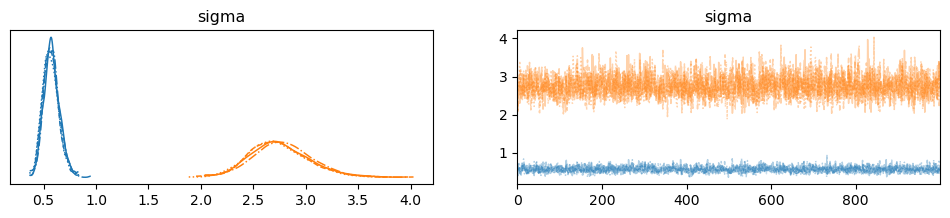

In [43]:
az.plot_trace(fit, var_names=['sigma']);

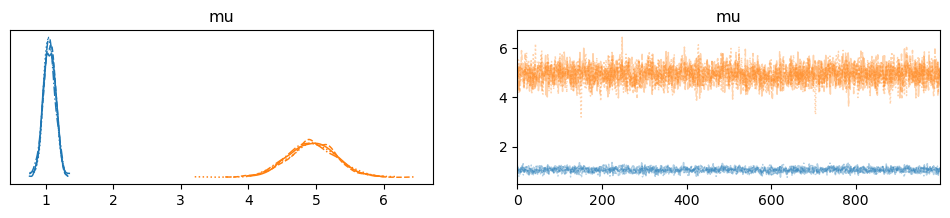

In [44]:
az.plot_trace(fit, var_names=['mu']);

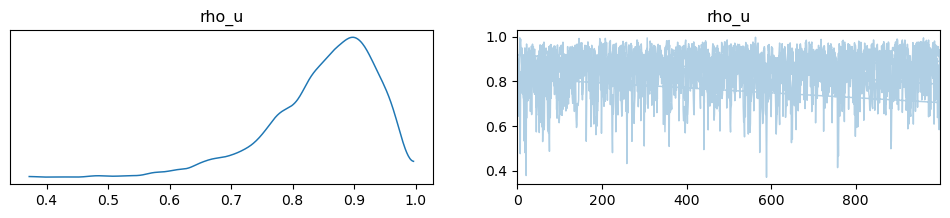

In [57]:
az.plot_trace(fit_df['rho_u'][1,0]);

The MCMC chains and generally follow a "Fuzzy caterpillar". There is a very low number of divergences. If any reader can suggest a way to remove please raise as an issue on the repository (of note tighter priors on the correlation is helpful, but then inconsistent with the Matske et al. implementation). What is particularly interesting is this is by no means a simple model to fit computationally. However, it demonstrates the utility of Hamiltonian monte carlo in giving the warning of divergences, (no matter how few) such that, any inferences have to be made with this in mind. In addition, despite the data here being simulated and therefore any inferences made being ultimately for demosntration, it does exemplify that this would be missed by any researcher using another MCMC algorithm. The pathologies that lead to divergences when using HMC still exist for other MCMC samplers McElreath (2020). These samplers, however, simple cannot provide these warnings when they fail in such ways.

In [63]:
# Get MCMC sample values
eta = fit_df['eta'].values

# Extract true parameter values
etal1 = []
etal2 = []
# Loop through and calcualte the means of the posterior samples. 
for i in range(len(df1)):
    eta1 = fit_df['eta'].values[i,0].mean()
    eta2 = fit_df['eta'].values[i,1].mean()
    etal1.append(eta1)
    etal2.append(eta2)

# Shrinkage

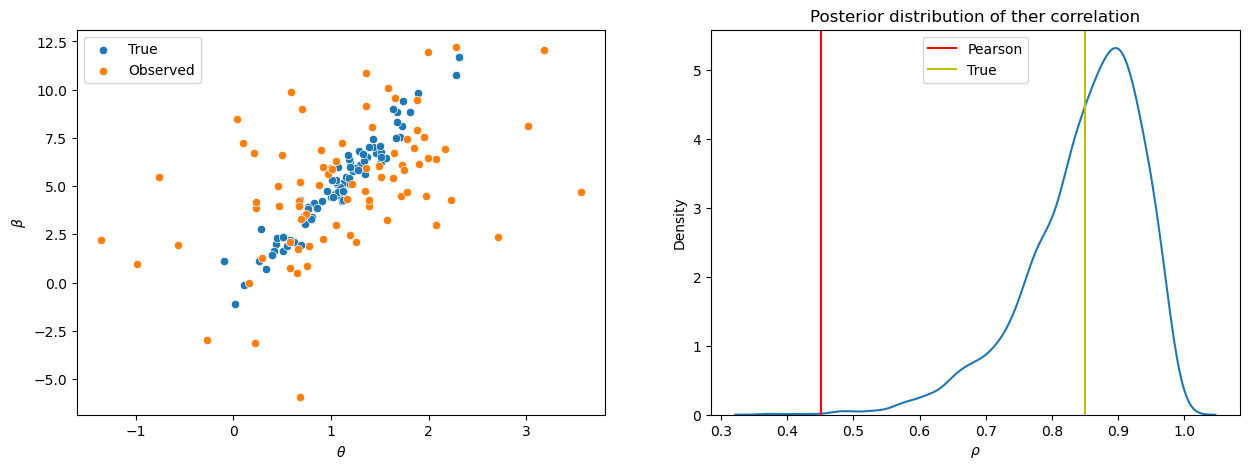

In [90]:
# Scatterplot showing the shrinkage effect from observed to infered true estimates
# after estiamting the correltion whilst accouting for the measurment errors of observed 
# values

# x coordiantes for vertical lines
xcoords = [pearsonr(df1['theta'], df1['beta'])[0], np.mean(fit_df['rho_u'][0,1])]

# Specify plot colours
col = ('y', 'r')
# Legend values
legend1 = ['True', 'Observed']
legend2 = ['Pearson', 'True']

# Plot Observed parameter values and Estimated true parameter values
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax= ax1,x = etal1, y = etal2);
sns.scatterplot(ax= ax1,x = df1['theta'], y = df1['beta']);
ax1.legend(legend)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\beta$')
ax1.legend(legend1)

# Plot kernel density for correlation parameters with 
# estimated True (posterior mean) and observed (pearson correlation)
sns.kdeplot(fit_df['rho_u'][0,1], ax=ax2);
plt.title("Posterior distribution of ther correlation")
ax2.set_xlabel(r'$\rho$');
line1 = ax2.axvline(xcoords[0], color=col[1], label=legend2[1])
line2 = ax2.axvline(xcoords[1], color=col[0], label=legend2[0])

# Create custom legend for the vertical lines
ax2.legend(handles=[line1, line2], labels=legend2);

The plots above shows for this particular (simulated) example there is a strong shrinkage effect from the observed parameter estimates to the true value estimates. Resulting in a much larger correlation estimate for the true correlation estimate being >.8.

# References

Behseta, S., Berdyyeva, T., Olson, C. R., & Kass, R. E. (2009). Bayesian correction for attenuation of correlation in multi-trial spike count data. Journal of neurophysiology, 101(4), 2186-2193.

Jeffreys, H. (1961). The theory of probability. OUP Oxford.

Matzke, D., Ly, A., Selker, R., Weeda, W. D., Scheibehenne, B., Lee, M. D., ... & Bouwmeester, S. (2017). Bayesian inference for correlations in the presence of measurement error and estimation uncertainty. Collabra: Psychology, 3(1).

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Saccenti, E., Hendriks, M. H., & Smilde, A. K. (2020). Corruption of the Pearson correlation coefficient by measurement error and its estimation, bias, and correction under different error models. Scientific reports, 10(1), 438.